In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./snr_ml_training/mlTrainingData.txt")

In [3]:
df = df.drop_duplicates(subset=['p_signal', 'p_noise', 'is_jammed'])
df['log_p_signal'] = np.log10(df['p_signal'] + 1e-12)
df['log_p_noise']  = np.log10(df['p_noise'] + 1e-12)
df['snr_db'] = 10 * np.log10(df['p_signal'] / df['p_noise'] + 1e-12)

In [4]:
X = df[['snr_db']]
y = df['is_jammed']

In [5]:
# Count each class
class_counts = df['is_jammed'].value_counts()
print(class_counts)

# Calculate percentage of each class
class_percentages = df['is_jammed'].value_counts(normalize=True) * 100
print(class_percentages)

is_jammed
0    753168
1    262929
Name: count, dtype: int64
is_jammed
0    74.123632
1    25.876368
Name: proportion, dtype: float64


In [6]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.is_jammed == 0]
df_minority = df[df.is_jammed == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,     # sample without replacement
                                   n_samples=len(df_minority),  # match minority count
                                   random_state=42)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Count each class
class_counts = df_balanced['is_jammed'].value_counts()
print(class_counts)

# Calculate percentage of each class
class_percentages = df_balanced['is_jammed'].value_counts(normalize=True) * 100
print(class_percentages)

is_jammed
0    262929
1    262929
Name: count, dtype: int64
is_jammed
0    50.0
1    50.0
Name: proportion, dtype: float64


In [8]:
X = df_balanced[['snr_db']]
y = df_balanced['is_jammed']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

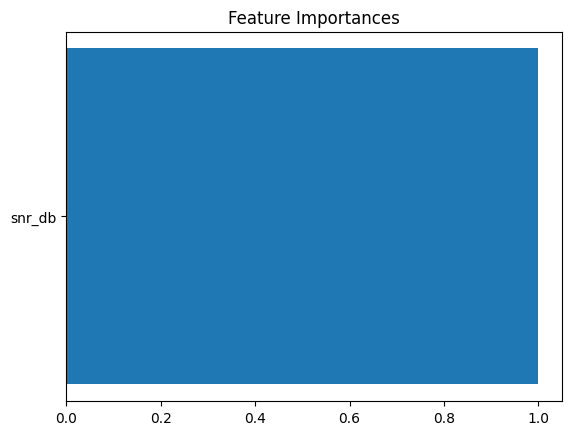

In [10]:
clf = RandomForestClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
features = X_train.columns
plt.barh(features, importances)
plt.title("Feature Importances")
plt.show()

In [11]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84     52489
           1       0.92      0.70      0.80     52683

    accuracy                           0.82    105172
   macro avg       0.84      0.82      0.82    105172
weighted avg       0.84      0.82      0.82    105172



In [12]:
import m2cgen as m2c
with open("./snr_ml_training/model.cpp", "w") as f:
    f.write(m2c.export_to_c(clf))
